# Import

To install libraries :

- Start the code
- Check which library is missing with the error it will give you
- In terminal, type : pip3 install "name of the library" --user

For fht : 

- Clone de repo at this link : https://github.com/nbarbery/fht
- Open a terminal at the root of spyrit
- cd fht
- pip3 install fht --user


In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import imageio
import cv2
import fht
import matplotlib.pyplot as plt
import scipy.io as sio
import PIL
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import wget
import zipfile
from pathlib import Path

In [2]:
spyritfolder = "D:\Creatis\Programmes\Python\openspyrit"
sys.path.insert(1, spyritfolder);
from spyrit.learning.model_Had_DCAN import *# compNet, Stat_had, Weight_Decay_Loss
from spyrit.learning.nets import *
from spyrit.misc.disp import *
from spyrit.misc.metrics import *

# Intialisation of parameters

In [3]:
batch_size = 1024
data_root = "./"
img_size = 64

transform = transforms.Compose(
    [
     transforms.functional.to_grayscale,
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])
    ])

# network Init
precompute_root_SDCAN = "models/SDCAN/"
precompute_root_IMNET = "models/IMNET/"

M = 1024
net_arch = 0    # among [0,2,3]

my_average_file_SDCAN = Path(precompute_root_SDCAN) / ('Average_{}x{}'.format(img_size, img_size)+'.npy')
my_cov_file_SDCAN = Path(precompute_root_SDCAN) / ('Cov_{}x{}'.format(img_size, img_size)+'.npy')

my_average_file_IMNET = Path(precompute_root_IMNET) / ('Average_{}x{}'.format(img_size, img_size)+'.npy')
my_cov_file_IMNET = Path(precompute_root_IMNET) / ('Cov_{}x{}'.format(img_size, img_size)+'.npy')

# network load
model_root_SDCAN = "models/SDCAN/"
model_root_IMNET = "models/IMNET/"

num_epochs = 5
lr = 1e-3
step_size = 10
gamma = 0.5
reg = 1e-7

# plot
nbr_to_disp = 1

# network evaluate
i_test = 1
if (i_test == -1) or (i_test >= batch_size - nbr_to_disp):
    i_test = random.randint(0, batch_size - nbr_to_disp)    # index of the images to display (smaller than batch size)

# CODE
## Initialisation of torch

In [4]:
torch.manual_seed(17)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Load datasets

In [5]:
testset_SDCAN = \
    torchvision.datasets.STL10(root=data_root, split='test', download=False, transform=transform)
testloader_SDCAN = \
    torch.utils.data.DataLoader(testset_SDCAN, batch_size=batch_size, shuffle=False)

testset_IMNET = \
    torchvision.datasets.ImageNet(root=data_root, split='val',  transform=transform)
testloader_IMNET = \
    torch.utils.data.DataLoader(testset_IMNET, batch_size=batch_size, shuffle=False)

dataloaders = {'val_SDCAN': testloader_SDCAN,'val_IMNET': testloader_IMNET}

## Create models

In [6]:
Path(precompute_root_SDCAN).mkdir(parents=True, exist_ok=True)

if not(my_average_file_SDCAN.is_file()) or not(my_cov_file_SDCAN.is_file()):
    print('Computing covariance and mean (overwrite previous files)')
    Mean_had_SDCAN, Cov_had_SDCAN = Stat_had(testloader_SDCAN, precompute_root_SDCAN)
else:
    print('Loading covariance and mean')
    Mean_had_SDCAN = np.load(my_average_file_SDCAN)
    Cov_had_SDCAN  = np.load(my_cov_file_SDCAN)

model_SDCAN = compNet(img_size, M, Mean_had_SDCAN, Cov_had_SDCAN, net_arch)

Loading covariance and mean
Measurement to image domain: statistical completion (no mean)


In [7]:
Path(precompute_root_IMNET).mkdir(parents=True, exist_ok=True)

if not(my_average_file_IMNET.is_file()) or not(my_cov_file_IMNET.is_file()):
    print('Computing covariance and mean (overwrite previous files)')
    Mean_had_IMNET, Cov_had_IMNET = Stat_had(testloader_IMNET, precompute_root_IMNET)
else:
    print('Loading covariance and mean')
    Mean_had_IMNET = np.load(my_average_file_IMNET)
    Cov_had_IMNET  = np.load(my_cov_file_IMNET)

model_IMNET = compNet(img_size, M, Mean_had_IMNET, Cov_had_IMNET, net_arch)

Loading covariance and mean
Measurement to image domain: statistical completion (no mean)


# Load network
## Search filename from parameters

In [8]:
net_type = ['c0mp', 'comp', 'pinv', 'free']

suffix = '_N_{}_M_{}_epo_{}_lr_{}_sss_{}_sdr_{}_bs_{}_reg_{}'.format( \
    img_size, M, num_epochs, lr, step_size, gamma, batch_size, reg)

In [9]:
filename_SDCAN = model_root_SDCAN + 'NET_' + net_type[net_arch] + suffix
model_SDCAN = model_SDCAN.to(device)
load_net(filename_SDCAN, model_SDCAN)

filename_IMNET = model_root_IMNET + 'NET_' + net_type[net_arch] + suffix
model_IMNET = model_IMNET.to(device)
load_net(filename_IMNET, model_IMNET)

Model Loaded: models/SDCAN/NET_c0mp_N_64_M_1024_epo_5_lr_0.001_sss_10_sdr_0.5_bs_1024_reg_1e-07
Model Loaded: models/IMNET/NET_c0mp_N_64_M_1024_epo_5_lr_0.001_sss_10_sdr_0.5_bs_1024_reg_1e-07


# Reconstruct an IMNET image through IMNET trained network

In [10]:
print('Evaluating image :')

# result lists
gt = []
data = []
rec = []

for i in range(nbr_to_disp):
    inputs, labels = next(iter(dataloaders['val_IMNET']))
    inputs = inputs.to(device)
    gt.append(inputs[(i_test + i):(i_test + i + 1), :, :, :].cpu().detach().numpy())
    x=inputs[(i_test + i):(i_test + i + 1), :, :, :]
    b,c,h,w = x.shape
    data.append(model_IMNET.T(model_IMNET.forward_acquire(x, b, c, h, w), \
         ).cpu().detach().numpy().squeeze())
    rec.append(model_IMNET.evaluate(x).cpu().detach().numpy().squeeze())
    print(i + 1, '/', nbr_to_disp, ' ')

Evaluating image :
1 / 1  


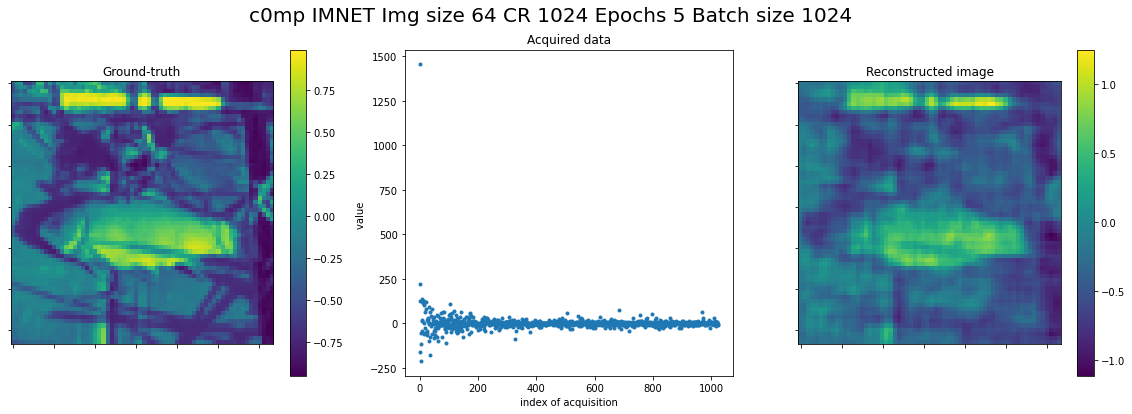

In [11]:
for i in range(nbr_to_disp):
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('c0mp' + ' IMNET Img size {} CR {} Epochs {} Batch size {}'.format( \
        img_size, M, num_epochs , batch_size), fontsize=20) 

    ax = axs[0]
    im = ax.imshow(gt[i][0,0,:,:])
    ax.set_title("Ground-truth")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(False)
    fig.colorbar(im, ax=ax)

    ax = axs[1]
    im = ax.plot(data[i],'.')
    ax.set_title("Acquired data")
    ax.set(ylabel="value ", xlabel="index of acquisition")
    ax.grid(False)

    ax = axs[2]
    im = ax.imshow(rec[i])
    ax.set_title("Reconstructed image")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(False)
    fig.colorbar(im, ax=ax)

    plt.show()

# See the hadamard patterns
To show hadamard patterns we will change the acquisition vector to set a coefficient to a certain value that will show how the image is acquired in the experiment

In [29]:
# Choose the index of the hadamard figure you want to display (max = 2*M)
i_had = 64

if i_had >= 2*M :
    i_had = 2*M-1

In [30]:
print('Evaluating image :')

# result lists
gt = []
data = []
rec = []

inputs = torch.zeros(1,1,img_size, img_size)
inputs = inputs.to(device)

gt.append(inputs[0:1, :, :, :].cpu().detach().numpy())
x2=inputs[0:1, :, :, :]
b,c,h,w = x2.shape
x2 = model_IMNET.forward_acquire(x2, b, c, h, w) #get image of hadamard transofrm
x2 = torch.zeros(x2.size())
x2[0,0,i_had] = 2000
x2 = x2.to(device)
data.append(model_IMNET.T(x2).cpu().detach().numpy().squeeze())
rec.append(model_IMNET.forward_maptoimage(x2, b, c, h, w).cpu().detach().numpy().squeeze())
print("1/1")

Evaluating image :
1/1


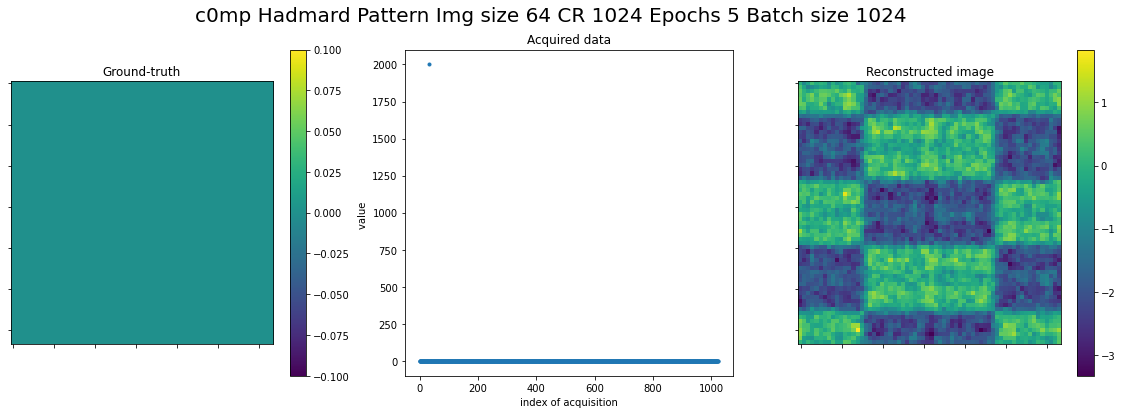

In [31]:
for i in range(1):
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('c0mp' + ' Hadmard Pattern Img size {} CR {} Epochs {} Batch size {}'.format( \
        img_size, M, num_epochs , batch_size), fontsize=20) 

    ax = axs[0]
    im = ax.imshow(gt[i][0,0,:,:])
    ax.set_title("Ground-truth")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(False)
    fig.colorbar(im, ax=ax)

    ax = axs[1]
    im = ax.plot(data[i],'.')
    ax.set_title("Acquired data")
    ax.set(ylabel="value ", xlabel="index of acquisition")
    ax.grid(False)

    ax = axs[2]
    im = ax.imshow(rec[i])
    ax.set_title("Reconstructed image")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(False)
    fig.colorbar(im, ax=ax)

    plt.show()

# Compare reconstruction through different networks

In [15]:
print('Evaluating image :')

# result lists
gt = []
data = []
rec = []

for i in range(nbr_to_disp):
    inputs, labels = next(iter(dataloaders['val_IMNET']))
    inputs = inputs.to(device)
    gt.append(inputs[(i_test + i):(i_test + i + 1), :, :, :].cpu().detach().numpy())
    gt.append(inputs[(i_test + i):(i_test + i + 1), :, :, :].cpu().detach().numpy())
    rec.append(model_IMNET.evaluate(x).cpu().detach().numpy().squeeze())
    rec.append(model_SDCAN.evaluate(x).cpu().detach().numpy().squeeze())
    print(i + 1, '/', nbr_to_disp, ' ')

Evaluating image :
1 / 1  


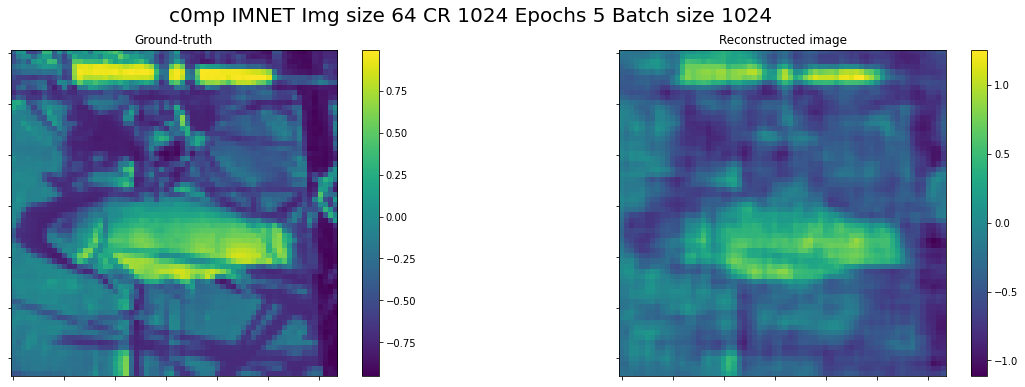

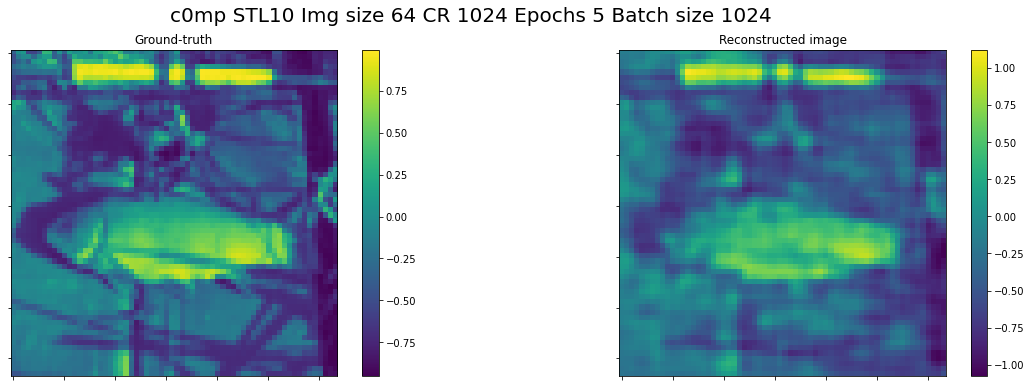

In [16]:
for i in range(nbr_to_disp):
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    fig.suptitle('c0mp' + ' IMNET Img size {} CR {} Epochs {} Batch size {}'.format( \
        img_size, M, num_epochs , batch_size), fontsize=20) 

    ax = axs[0]
    im = ax.imshow(gt[i*2][0,0,:,:])
    ax.set_title("Ground-truth")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(False)
    fig.colorbar(im, ax=ax)

    ax = axs[1]
    im = ax.imshow(rec[i*2])
    ax.set_title("Reconstructed image")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(False)
    fig.colorbar(im, ax=ax)

    plt.show()
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    fig.suptitle('c0mp' + ' STL10 Img size {} CR {} Epochs {} Batch size {}'.format( \
        img_size, M, num_epochs , batch_size), fontsize=20) 

    ax = axs[0]
    im = ax.imshow(gt[i*2+1][0,0,:,:])
    ax.set_title("Ground-truth")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(False)
    fig.colorbar(im, ax=ax)

    ax = axs[1]
    im = ax.imshow(rec[i*2+1])
    ax.set_title("Reconstructed image")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(False)
    fig.colorbar(im, ax=ax)

    plt.show()

As IMNET is trained on the data we are giving to the two networks here, it will be more proeficient in reconstructing them.
Also STL10 has images smaller than 64x64 so it as also less data to train on 64x64 pictures.

# Compare different number of acquisitions (M)

In [17]:
Path(precompute_root_IMNET).mkdir(parents=True, exist_ok=True)

if not(my_average_file_IMNET.is_file()) or not(my_cov_file_IMNET.is_file()):
    print('Computing covariance and mean (overwrite previous files)')
    Mean_had_IMNET, Cov_had_IMNET = Stat_had(testloader_IMNET, precompute_root_IMNET)
else:
    print('Loading covariance and mean')
    Mean_had_IMNET = np.load(my_average_file_IMNET)
    Cov_had_IMNET  = np.load(my_cov_file_IMNET)

model_IMNET_2048 = compNet(img_size, 2048, Mean_had_IMNET, Cov_had_IMNET, net_arch)
model_IMNET_333 = compNet(img_size, 333, Mean_had_IMNET, Cov_had_IMNET, net_arch)

Loading covariance and mean
Measurement to image domain: statistical completion (no mean)
Measurement to image domain: statistical completion (no mean)


In [18]:
suffix = '_N_{}_M_{}_epo_{}_lr_{}_sss_{}_sdr_{}_bs_{}_reg_{}'.format( \
    img_size, 2048, num_epochs, lr, step_size, gamma, batch_size, reg)

filename_IMNET_2048 = model_root_IMNET + 'NET_' + net_type[net_arch] + suffix
model_IMNET_2048 = model_IMNET_2048.to(device)
load_net(filename_IMNET_2048, model_IMNET_2048)

suffix = '_N_{}_M_{}_epo_{}_lr_{}_sss_{}_sdr_{}_bs_{}_reg_{}'.format( \
    img_size, 333, num_epochs, lr, step_size, gamma, batch_size, reg)

filename_IMNET_333 = model_root_IMNET + 'NET_' + net_type[net_arch] + suffix
model_IMNET_333 = model_IMNET_333.to(device)
load_net(filename_IMNET_333, model_IMNET_333)

Model Loaded: models/IMNET/NET_c0mp_N_64_M_2048_epo_5_lr_0.001_sss_10_sdr_0.5_bs_1024_reg_1e-07
Model Loaded: models/IMNET/NET_c0mp_N_64_M_333_epo_5_lr_0.001_sss_10_sdr_0.5_bs_1024_reg_1e-07


In [19]:
print('Evaluating image :')

# result lists
gt = []
data = []
rec = []

for i in range(nbr_to_disp):
    inputs, labels = next(iter(dataloaders['val_IMNET']))
    inputs = inputs.to(device)
    x=inputs[(i_test + i):(i_test + i + 1), :, :, :]
    gt.append(x.cpu().detach().numpy())
    gt.append(x.cpu().detach().numpy())
    gt.append(x.cpu().detach().numpy())
    rec.append(model_IMNET_333.evaluate(x).cpu().detach().numpy().squeeze())
    rec.append(model_IMNET.evaluate(x).cpu().detach().numpy().squeeze())
    rec.append(model_IMNET_2048.evaluate(x).cpu().detach().numpy().squeeze())
    print(i + 1, '/', nbr_to_disp, ' ')

Evaluating image :
1 / 1  


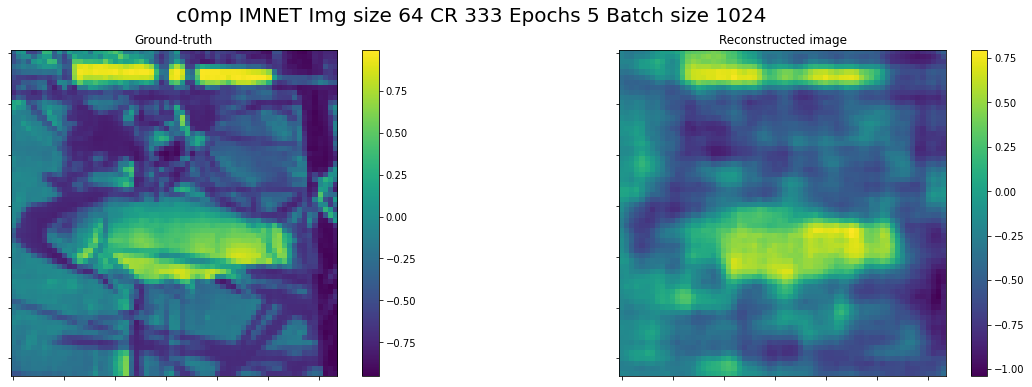

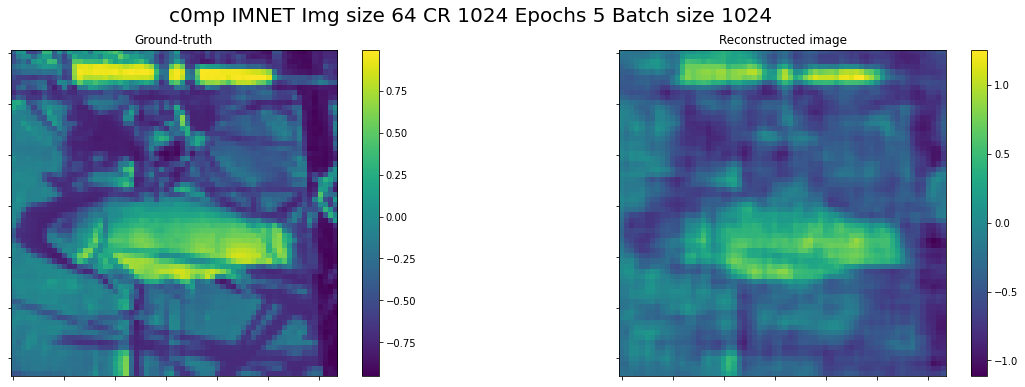

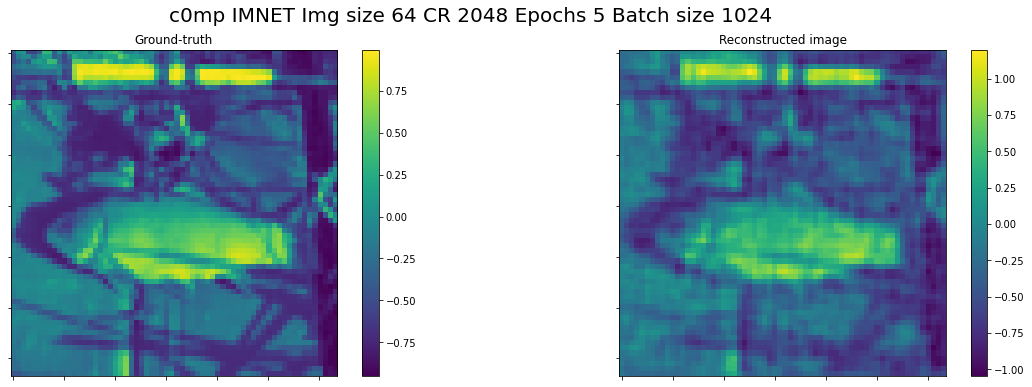

In [20]:
for i in range(nbr_to_disp):
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    fig.suptitle('c0mp' + ' IMNET Img size {} CR 333 Epochs {} Batch size {}'.format( \
        img_size, num_epochs , batch_size), fontsize=20) 

    ax = axs[0]
    im = ax.imshow(gt[i*3][0,0,:,:])
    ax.set_title("Ground-truth")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(False)
    fig.colorbar(im, ax=ax)

    ax = axs[1]
    im = ax.imshow(rec[i*3])
    ax.set_title("Reconstructed image")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(False)
    fig.colorbar(im, ax=ax)

    
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    fig.suptitle('c0mp' + ' IMNET Img size {} CR {} Epochs {} Batch size {}'.format( \
        img_size, M, num_epochs , batch_size), fontsize=20) 

    ax = axs[0]
    im = ax.imshow(gt[i*3+1][0,0,:,:])
    ax.set_title("Ground-truth")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(False)
    fig.colorbar(im, ax=ax)

    ax = axs[1]
    im = ax.imshow(rec[i*3+1])
    ax.set_title("Reconstructed image")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(False)
    fig.colorbar(im, ax=ax)

    plt.show()
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    fig.suptitle('c0mp' + ' IMNET Img size {} CR 2048 Epochs {} Batch size {}'.format( \
        img_size, num_epochs , batch_size), fontsize=20) 

    ax = axs[0]
    im = ax.imshow(gt[i*3+2][0,0,:,:])
    ax.set_title("Ground-truth")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(False)
    fig.colorbar(im, ax=ax)

    ax = axs[1]
    im = ax.imshow(rec[i*3+2])
    ax.set_title("Reconstructed image")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(False)
    fig.colorbar(im, ax=ax)

    plt.show()

# Compare 128x128 images reconstruction methods
Warning : unfortunatly we didn't manage to make the bloc reconstruction work in jupyter so you need to execute cc_blocs.py script

In [21]:
transform = transforms.Compose(
    [
     transforms.functional.to_grayscale,
     transforms.Resize((128, 128)),
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])
    ])

testset_IMNET_128 = \
    torchvision.datasets.ImageNet(root=data_root, split='val',  transform=transform)
testloader_IMNET_128 = \
    torch.utils.data.DataLoader(testset_IMNET_128, batch_size=batch_size, shuffle=False)

dataloaders.update({'val_IMNET_128': testloader_IMNET_128})

In [22]:
my_average_file_IMNET_128 = Path(precompute_root_IMNET) / ('Average_{}x{}'.format(128, 128)+'.npy')
my_cov_file_IMNET_128 = Path(precompute_root_IMNET) / ('Cov_{}x{}'.format(128, 128)+'.npy')

Path(precompute_root_IMNET).mkdir(parents=True, exist_ok=True)

if not(my_average_file_IMNET_128.is_file()) or not(my_cov_file_IMNET_128.is_file()):
    print('Computing covariance and mean (overwrite previous files)')
    Mean_had_IMNET_128, Cov_had_IMNET_128 = Stat_had(testloader_IMNET, precompute_root_IMNET)
else:
    print('Loading covariance and mean')
    Mean_had_IMNET_128 = np.load(my_average_file_IMNET_128)
    Cov_had_IMNET_128  = np.load(my_cov_file_IMNET_128)

model_IMNET_128 = compNet(128, 333, Mean_had_IMNET_128, Cov_had_IMNET_128, net_arch)

Loading covariance and mean
Measurement to image domain: statistical completion (no mean)


In [23]:
suffix = '_N_{}_M_{}_epo_{}_lr_{}_sss_{}_sdr_{}_bs_{}_reg_{}'.format( \
    128, 333, 10, lr, step_size, gamma, 256, reg)

filename_IMNET_128 = model_root_IMNET + 'NET_' + net_type[net_arch] + suffix
model_IMNET_128 = model_IMNET_128.to(device)
load_net(filename_IMNET_128, model_IMNET_128)

Model Loaded: models/IMNET/NET_c0mp_N_128_M_333_epo_10_lr_0.001_sss_10_sdr_0.5_bs_256_reg_1e-07


In [24]:
print('Evaluating image :')

# result lists
gt = []
data = []
rec = []

for i in range(nbr_to_disp):
    inputs, labels = next(iter(dataloaders['val_IMNET_128']))
    inputs = inputs.to(device)
    gt.append(inputs[(i_test + i):(i_test + i + 1), :, :, :].cpu().detach().numpy())
    x=inputs[(i_test + i):(i_test + i + 1), :, :, :]
    b,c,h,w = x.shape
    data.append(model_IMNET_128.T(model_IMNET_128.forward_acquire(x, b, c, h, w), \
         ).cpu().detach().numpy().squeeze())
    rec.append(model_IMNET_128.evaluate(x).cpu().detach().numpy().squeeze())
    print(i + 1, '/', nbr_to_disp, ' ')

Evaluating image :
1 / 1  


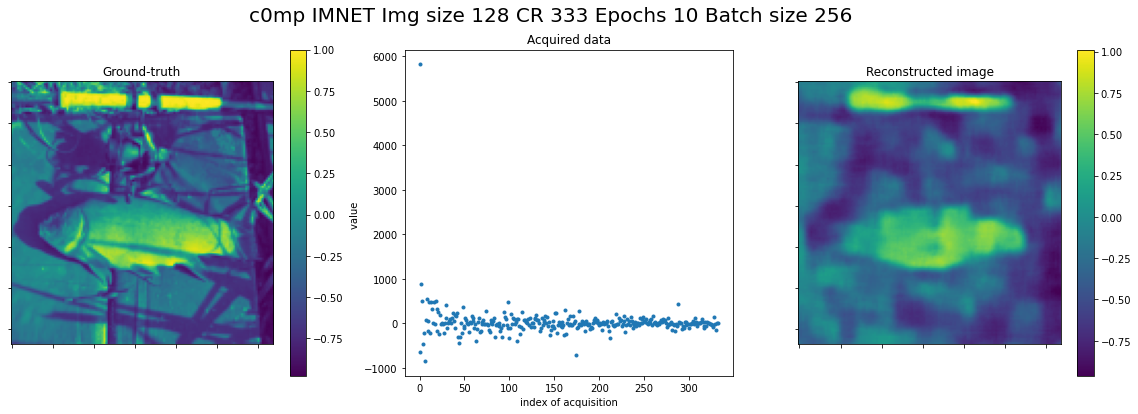

In [25]:
for i in range(nbr_to_disp):
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('c0mp' + ' IMNET Img size {} CR {} Epochs {} Batch size {}'.format( \
        128, 333, 10 , 256), fontsize=20) 

    ax = axs[0]
    im = ax.imshow(gt[i][0,0,:,:])
    ax.set_title("Ground-truth")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(False)
    fig.colorbar(im, ax=ax)

    ax = axs[1]
    im = ax.plot(data[i],'.')
    ax.set_title("Acquired data")
    ax.set(ylabel="value ", xlabel="index of acquisition")
    ax.grid(False)

    ax = axs[2]
    im = ax.imshow(rec[i])
    ax.set_title("Reconstructed image")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(False)
    fig.colorbar(im, ax=ax)

    plt.show()